In [ ]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/1D_Allen-Cahn

AC_data_input.npy   Fourier_Neural_Operator
AC_data_output.npy  Original_Tutorial_05_Operator_Learing_Fourier_Neural_Operator.ipynb


---

### Model Summary Function

In [ ]:
def model_summary(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    total_params+=params
    print(table)
    print(f'Total Trainable Params: {total_params}')
    return total_params

### New Directories

In [ ]:
# Define directory for saving checkpoints
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
# Create directory
save_dir = "plots"
os.makedirs(save_dir, exist_ok=True)

## Plots

### SINGLE PLOT FUNCTION

In [ ]:
def single_plot(model_name):
  """
  Plots the true vs approximate solutions for a randomly selected test sample and computes error metrics.

  Args:
  model_name (torch.nn.Module): The trained model used for predicting the output for a given input sample.

  The function prints the following information for the selected test sample:
      - Test sample index
      - Relative L2 error in percentage
      - Mean Absolute Error (MAE)
      - Root Mean Squared Error (RMSE)
      - R² Score

  """

  # random test sample index
  idx_data = np.random.randint(0, len(input_function_test) - 1)

  input_function_test_n = input_function_test[idx_data, :].unsqueeze(0)

  output_function_test_n = output_function_test[idx_data, :].unsqueeze(0)

  # predict the output function for the selected input
  output_function_test_pred_n = model_name(input_function_test_n)


  plt.figure()
  plt.grid(True, which="both", ls=":")
  plt.plot(
      input_function_test_n[0,:,1].detach(),
      output_function_test_n[0].detach(),
      label="True Solution",
      c="C0",
      lw=2
  )
  plt.scatter(
      input_function_test_n[0,:,1].detach(),
      output_function_test_pred_n[0].detach(),
      label="Approximate Solution",
      s=8,
      c="C1"
  )
  plt.legend()
  plt.title(f"Test Index: {idx_data}")

  # Save the plot
  model_class_name = model_name.__class__.__name__.lower()
  plot_filename = os.path.join(save_dir, f"{model_class_name}_test_sample_{idx_data}.png")
  plt.savefig(plot_filename, dpi=300)

  print(f"Plot saved at: {plot_filename}")

  p = 2
  err = (torch.mean(abs(output_function_test_n.detach().reshape(-1, ) - output_function_test_pred_n.detach().reshape(-1, )) ** p) /
       torch.mean(abs(output_function_test_n.detach()) ** p)) ** (1 / p) * 100

  plt.legend()

### TRUE VS APPROXIMATION GRID FUNCTION

In [ ]:
def true_vs_approx(model_name):
  """
  Plots the true vs approximate solutions for random test samples using 3x3 grid.

  Args:
  model_name (torch.nn.Module): The trained model to be used for prediction. It should take input samples
                                  and return the predicted output.

  """

  # 9 random test samples
  num_samples = 9
  indices = np.random.randint(0, len(input_function_test) - 1, num_samples)

  # Create subplots (3x3)
  fig, axes = plt.subplots(3, 3, figsize=(12, 12))
  fig.suptitle("True vs Approximate Solution for Random Test Samples", fontsize=16)

  p = 2

  for i, idx_data in enumerate(indices):
      ax = axes[i // 3, i % 3]

      input_function_test_n = input_function_test[idx_data, :].unsqueeze(0)
      output_function_test_n = output_function_test[idx_data, :].unsqueeze(0)

      # Use trained model to predict output
      output_function_test_pred_n = model_name(input_function_test_n)

      err = (torch.mean(abs(output_function_test_n.detach().reshape(-1, ) -
                          output_function_test_pred_n.detach().reshape(-1, )) ** p) /
          torch.mean(abs(output_function_test_n.detach()) ** p)) ** (1 / p) * 100

      # Plot true vs approximate solution
      ax.grid(True, which="both", ls=":")
      ax.plot(input_function_test_n[0, :, 1].detach(),
              output_function_test_n[0].detach(),
              label="True Solution",
              c="C0",
              lw=2)

      ax.scatter(input_function_test_n[0, :, 1].detach(),
                output_function_test_pred_n[0].detach(),
                label="Approximate Solution",
                s=8,
                c="C1")

      ax.set_title(f"Test Index {idx_data} | Rel. L2: {err:.2f}%")
      ax.legend()

  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

  # Save the plot
  model_class_name = model_name.__class__.__name__.lower()
  plot_filename = os.path.join(save_dir, f"{model_class_name}model_true_vs_approx_3x3_grid.png")
  plt.savefig(plot_filename, dpi=300)

  print(f"Plot saved at: {plot_filename}")


## Data Inspection and Visualization

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
# Number of training samples to be used
n_train = 100

# initial conditions and spatial coordinates
x_data = torch.from_numpy(np.load("/content/drive/MyDrive/1D_Allen-Cahn/AC_data_input.npy")).type(torch.float32)

# solution of the equation at a later timestep
y_data = torch.from_numpy(np.load("/content/drive/MyDrive/1D_Allen-Cahn/AC_data_output.npy")).type(torch.float32)

# Swap the first and second channels in the input tensor
temporary_tensor = torch.clone(x_data[:, :, 0])
x_data[:, :, 0] = x_data[:, :, 1]
x_data[:, :, 1] = temporary_tensor

# Split the dataset into training and testing sets
input_function_train = x_data[:n_train, :]
output_function_train = y_data[:n_train, :]

input_function_test = x_data[n_train:, :]
output_function_test = y_data[n_train:, :]

batch_size = 10

# Create a DataLoader for training data
training_set = DataLoader(TensorDataset(input_function_train, output_function_train), batch_size=batch_size, shuffle=True)

# Create a DataLoader for testing data
testing_set = DataLoader(TensorDataset(input_function_test, output_function_test), batch_size=batch_size, shuffle=False)


Text(0.5, 1.0, 'Visualization of Sample ID: 44')

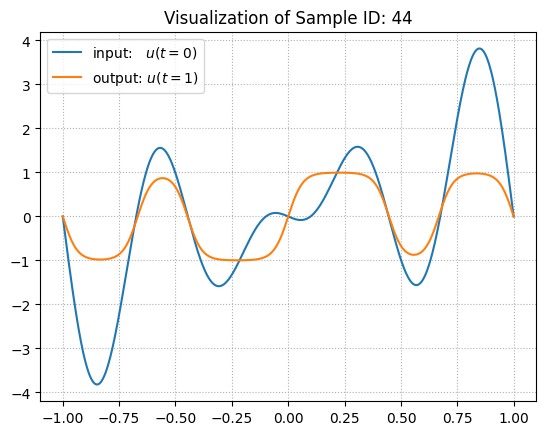

In [ ]:
# random sample index within the training set
id_sample = np.random.randint(0, n_train)

plt.plot(
    np.linspace(-1, 1, input_function_train.shape[1]),
    input_function_train[id_sample, :, 0],
    label="input:   $u(t = 0)$"
)

plt.plot(
    np.linspace(-1, 1, input_function_train.shape[1]),
    output_function_train[id_sample, :],
    label="output: $u(t = 1)$"
)

plt.grid(True, which="both", ls=":")

plt.legend()

plt.title(f"Visualization of Sample ID: {id_sample}")

Input Data Shape: torch.Size([1000, 1001, 2])
Output Data Shape: torch.Size([1000, 1001])
Number of Samples: 1000
Time Steps: 1001
Number of Features in Input: 2


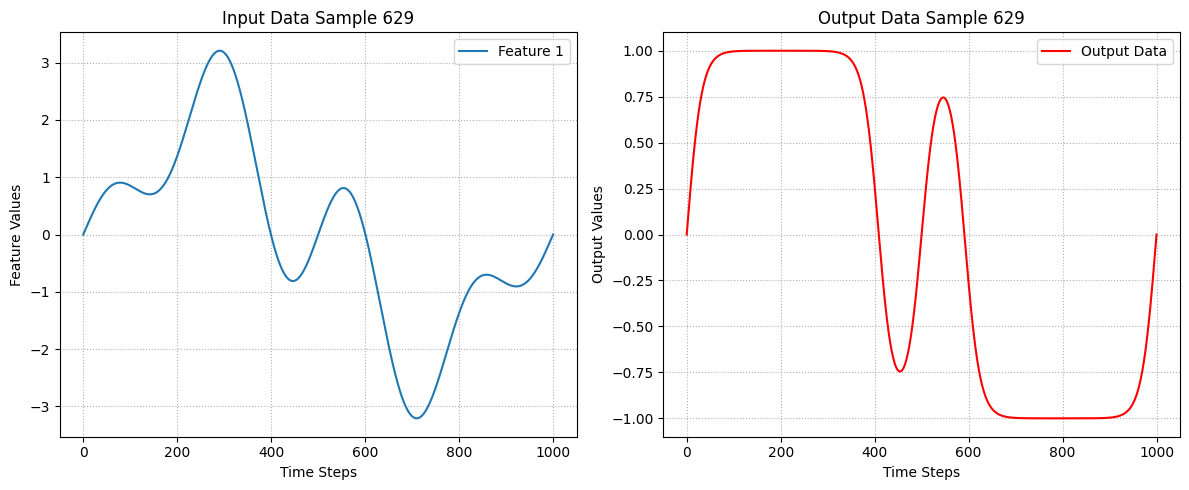

In [ ]:
input_data = x_data
output_data = y_data

print(f"Input Data Shape: {input_data.shape}")
print(f"Output Data Shape: {output_data.shape}")

num_samples = input_data.shape[0]
time_steps = input_data.shape[1] if len(input_data.shape) > 1 else 1
num_features = input_data.shape[2] if len(input_data.shape) > 2 else 1

print(f"Number of Samples: {num_samples}")
print(f"Time Steps: {time_steps}")
print(f"Number of Features in Input: {num_features}")

# Visualize a few sample inputs and outputs
sample_idx = np.random.randint(0, num_samples)
plt.figure(figsize=(12, 5))

# Plot Input Data
plt.subplot(1, 2, 1)
for feature in range(num_features):
    if feature == 1:  # Skip Feature 2 (index 1)
        continue
    plt.plot(range(time_steps), input_data[sample_idx, :, feature], label=f'Feature {feature+1}')
plt.title(f'Input Data Sample {sample_idx}')
plt.xlabel('Time Steps')
plt.ylabel('Feature Values')
plt.legend()
plt.grid(True, linestyle=':')


# Plot Output Data
plt.subplot(1, 2, 2)
plt.plot(range(time_steps), output_data[sample_idx, :], label='Output Data', color='r')
plt.title(f'Output Data Sample {sample_idx}')
plt.xlabel('Time Steps')
plt.ylabel('Output Values')
plt.legend()
plt.grid(True, linestyle=':')

plt.tight_layout()
plt.show()


## Fourier Neural Operator (FNO)


In [ ]:
def activation(name="relu"):  # Default to ReLU
    name = name.lower()
    activations = {
        "tanh": nn.Tanh(),
        "relu": nn.ReLU(inplace=True),
        "lrelu": nn.LeakyReLU(inplace=True),
        "sigmoid": nn.Sigmoid(),
        "softplus": nn.Softplus(beta=4),
        "celu": nn.CELU(),
        "elu": nn.ELU(),
        "mish": nn.Mish(),
    }
    if name in activations:
        return activations[name]
    else:
        raise ValueError(f"Unknown activation function: {name}")

## FOURIER LAYER

In [ ]:
# Define a Spectral Convolution Layer in 1D using Fourier Transform
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer: It applies FFT, performs a learnable transformation in the frequency domain,
        and then applies the inverse FFT to bring the data back to the spatial domain.
        """

        # Number of input and output channels
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Number of Fourier modes
        self.modes1 = modes1

        # Scaling factor
        self.scale = (1 / (in_channels * out_channels))

        # Learnable weight parameters (complex numbers) for the Fourier modes
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication in the Fourier domain
    def compl_mul1d(self, input, weights):
        """
        Performs complex multiplication between input Fourier coefficients and learnable weights.
        Uses Einstein summation notation for efficient tensor multiplication.

        Args:
            input: Fourier-transformed input tensor of shape (batch, in_channels, frequency modes)
            weights: Learnable weight tensor of shape (in_channels, out_channels, frequency modes)

        Returns:
            Tensor of shape (batch, out_channels, frequency modes)
        """
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        """
        Forward pass of the Spectral Convolution Layer.
        1. Apply FFT to transform input to frequency domain.
        2. Multiply the first 'modes1' Fourier coefficients with learnable weights.
        3. Apply inverse FFT to transform back to spatial domain.

        Args:
            x: Input tensor of shape (batch_size, in_channels, number of grid points)

        Returns:
            Transformed tensor of the same shape as input.
        """

        batchsize = x.shape[0]

        # Step 1
        x_ft = torch.fft.rfft(x)

        # Step 2
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)

        # Step 3
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Step 4
        x = torch.fft.irfft(out_ft, n=x.size(-1))

        return x


In [ ]:
# Define the Fourier Neural Operator (FNO) for 1D problems
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall structure of the Fourier Neural Operator (FNO):
        1. Lift the input to a higher-dimensional space using `self.linear_p`.
        2. Apply multiple layers of Fourier-based convolution (`SpectralConv1d`).
        3. Apply linear transformations (`Conv1d`) after each Fourier layer.
        4. Project the output to the desired final dimension (`self.linear_q` and `self.output_layer`).

        Input:  (batch_size, x=s, c=2) -> initial condition and spatial coordinate (u0(x), x)
        Output: (batch_size, x=s, c=1) -> solution at a later time step
        """

        # Number of Fourier modes
        self.modes1 = modes

        # Number of channels
        self.width = width

        self.padding = 1

        # Initial linear layer to lift the input dimension
        self.linear_p = nn.Linear(2, self.width)

        # layers to capture global dependencies
        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)

        # layers to refine local features after each Fourier layer
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        # Final linear layers to project to the output dimension
        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        # Activation function (Tanh) for non-linearity
        self.activation = torch.nn.Tanh()

    # Function to apply a Fourier convolution + pointwise linear transformation
    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    # Function to apply a linear transformation followed by activation
    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        """
        Steps:
        1. Lift the input to a higher-dimensional space.
        2. Apply spectral convolution layers followed by linear transformations.
        3. Project the output to the final shape.
        """

        # Step 1
        x = self.linear_p(x)

        x = x.permute(0, 2, 1)

        # Step 2
        x = self.fourier_layer(x, self.spect1, self.lin0)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        x = self.fourier_layer(x, self.spect3, self.lin2)

        x = x.permute(0, 2, 1)

        # Step 3
        x = self.linear_layer(x, self.linear_q)  # Reduce dimension to 32
        x = self.output_layer(x)  # Final projection to 1D output

        return x


## Training

In [ ]:
learning_rate = 0.001
epochs = 30
step_size = 50
gamma = 0.5

In [ ]:
modes = 16
width = 64
fno = FNO1d(modes, width) # model

In [ ]:
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

mse_loss_fn = torch.nn.MSELoss()
mae_loss_fn = torch.nn.L1Loss()

train_mse_history = []
train_mae_history = []
train_rmse_history = []

test_mse_history = []
test_mae_history = []
test_r2_history = []
test_rmse_history = []
test_relative_l2_history = []

freq_print = 1

# Training Loop
for epoch in range(epochs):
    fno.train()
    train_mse, train_mae, train_rmse = 0.0, 0.0, 0.0

    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()

        output_pred_batch = fno(input_batch).squeeze(2)

        loss_mse = mse_loss_fn(output_pred_batch, output_batch)
        loss_mse.backward()

        optimizer.step()

        loss_mae = mae_loss_fn(output_pred_batch, output_batch)
        loss_rmse = torch.sqrt(loss_mse)

        train_mse += loss_mse.item()
        train_mae += loss_mae.item()
        train_rmse += loss_rmse.item()

    train_mse /= len(training_set)
    train_mae /= len(training_set)
    train_rmse /= len(training_set)

    train_mse_history.append(train_mse)
    train_mae_history.append(train_mae)
    train_rmse_history.append(train_rmse)

    scheduler.step()

    fno.eval()
    test_mse, test_mae, test_rmse, test_r2, test_relative_l2 = 0.0, 0.0, 0.0, 0.0, 0.0

    with torch.no_grad():
        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = fno(input_batch).squeeze(2)

            mse = mse_loss_fn(output_pred_batch, output_batch)
            mae = mae_loss_fn(output_pred_batch, output_batch)
            rmse = torch.sqrt(mse)

            relative_l2 = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100

            ss_total = torch.sum((output_batch - torch.mean(output_batch)) ** 2)
            ss_residual = torch.sum((output_batch - output_pred_batch) ** 2)
            r2_score = 1 - (ss_residual / ss_total)

            test_mse += mse.item()
            test_mae += mae.item()
            test_rmse += rmse.item()
            test_relative_l2 += relative_l2.item()
            test_r2 += r2_score.item()

        test_mse /= len(testing_set)
        test_mae /= len(testing_set)
        test_rmse /= len(testing_set)
        test_relative_l2 /= len(testing_set)
        test_r2 /= len(testing_set)

        test_mse_history.append(test_mse)
        test_mae_history.append(test_mae)
        test_rmse_history.append(test_rmse)
        test_relative_l2_history.append(test_relative_l2)
        test_r2_history.append(test_r2)

    # training and test metrics
        if epoch % freq_print == 0:
          print(f"\nEpoch: {epoch}")
          print(f"{'Metric':<20}{'Train':<20}{'Test'}")
          print("-" * 60)
          print(f"{'MSE':<20}{train_mse:<20f}{test_mse:.6f}")
          print(f"{'MAE':<20}{train_mae:<20f}{test_mae:.6f}")
          print(f"{'RMSE':<20}{train_rmse:<20f}{test_rmse:.6f}")
          print(f"{'R²':<20}{'-':<20}{test_r2:.6f}")  # only for test
          print(f"{'Relative L2 (%)':<20}{'-':<20}{test_relative_l2:.6f}%")  # Only for test


Epoch: 0
Metric              Train               Test
------------------------------------------------------------
MSE                 0.304186            0.104756
MAE                 0.450140            0.281827
RMSE                0.508468            0.322856
R²                  -                   0.847114
Relative L2 (%)     -                   38.978489%

Epoch: 1
Metric              Train               Test
------------------------------------------------------------
MSE                 0.063486            0.043762
MAE                 0.198168            0.150830
RMSE                0.242711            0.206607
R²                  -                   0.936317
Relative L2 (%)     -                   24.926397%

Epoch: 2
Metric              Train               Test
------------------------------------------------------------
MSE                 0.036171            0.019401
MAE                 0.125426            0.098208
RMSE                0.180823            0.136726
R²         

In [ ]:
model_summary(fno)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|   linear_p.weight   |    128     |
|    linear_p.bias    |     64     |
|   spect1.weights1   |   65536    |
|   spect2.weights1   |   65536    |
|   spect3.weights1   |   65536    |
|     lin0.weight     |    4096    |
|      lin0.bias      |     64     |
|     lin1.weight     |    4096    |
|      lin1.bias      |     64     |
|     lin2.weight     |    4096    |
|      lin2.bias      |     64     |
|   linear_q.weight   |    2048    |
|    linear_q.bias    |     32     |
| output_layer.weight |     32     |
|  output_layer.bias  |     1      |
+---------------------+------------+
Total Trainable Params: 211393


211393

## Plots

Plot saved at: plots/fno1d_test_sample_629.png


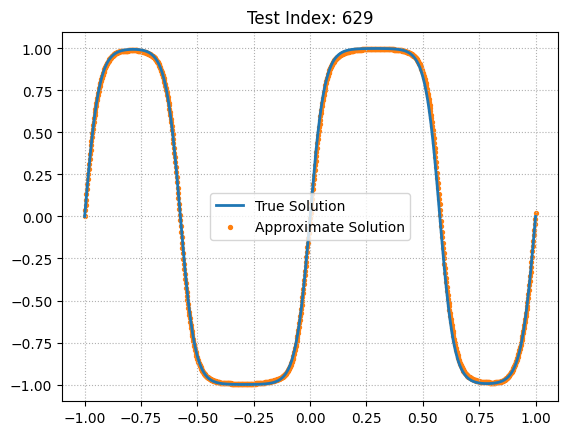

In [ ]:
single_plot(fno)

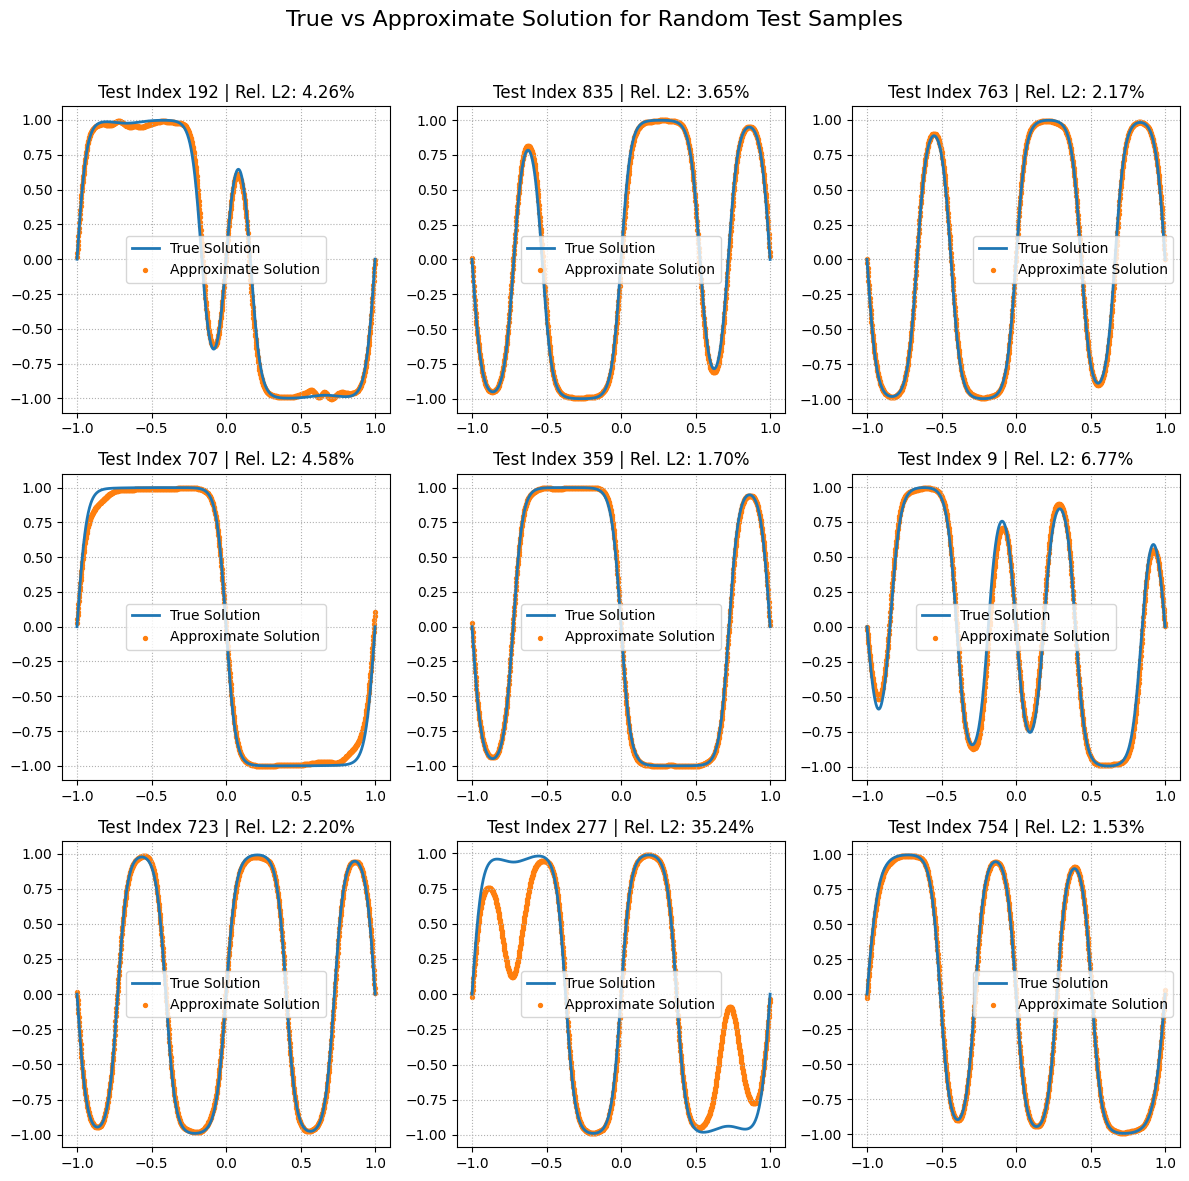

Plot saved at: plots/fno1dmodel_true_vs_approx_3x3_grid.png


<Figure size 640x480 with 0 Axes>

In [ ]:
true_vs_approx(fno)

## Checkpoints

### Saving the Model

In [ ]:
model = fno

checkpoint_path = os.path.join(checkpoint_dir, f"model1_checkpoint.pth")

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Save checkpoint with more training statistics
checkpoint1 = {
    'model_name': model,
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_mse_history': train_mse_history,
    'train_mae_history': train_mae_history,
    'train_rmse_history': train_rmse_history,
    'test_mse_history': test_mse_history,
    'test_mae_history': test_mae_history,
    'test_rmse_history': test_rmse_history,
    'test_r2_history': test_r2_history,
    'test_relative_l2_history': test_relative_l2_history,
    'min_test_loss': min(test_mse_history),
    'total_params': total_params,
}
torch.save(checkpoint1, checkpoint_path)

fno_info = [checkpoint1.copy()]

print(f"Checkpoint saved successfully at: {checkpoint_path}")


Checkpoint saved successfully at: checkpoints/model1_checkpoint.pth


In [ ]:
fno_info = {
    'model_name': model.__class__.__name__,
    'test_mse_history': test_mse_history[-1],
    'test_mae_history': test_mae_history[-1],
    'test_rmse_history': test_rmse_history[-1],
    'test_r2_history': test_r2_history[-1],
    'test_relative_l2_history': test_relative_l2_history[-1],
    'min_test_loss': min(test_mse_history),
    'total_params': total_params,
}

# Convert the dictionary values to a list
fno_info_list = list(fno_info.values())



### Load Model Checkpoint

In [ ]:
# Load the saved checkpoint
checkpoint1 = torch.load('checkpoints/model1_checkpoint.pth')

# Restore model & optimizer states
model.load_state_dict(checkpoint1['model_state_dict'])
optimizer.load_state_dict(checkpoint1['optimizer_state_dict'])

# Extract additional stats
epoch = checkpoint1['epoch']
train_loss_history = checkpoint1['train_mse_history']
test1_loss_history = checkpoint1['test_relative_l2_history']
min_test_loss = checkpoint1['min_test_loss']
total_params = checkpoint1['total_params']

# Print key statistics
print(f"Resuming from Epoch: {epoch}")
print(f"Total Trainable Parameters: {total_params}")
print(f"Final Training Loss: {train_mse_history[-1]}")
print(f"Final Testing Loss: {test_relative_l2_history[-1]}")
print(f"Lowest Testing Loss Achieved: {min_test_loss}")

Resuming from Epoch: 29
Total Trainable Parameters: 211393
Final Training Loss: 0.0006235767199541442
Final Testing Loss: 5.293021991517809
Lowest Testing Loss Achieved: 0.002129526881455806


<ipython-input-26-359edf7e893d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint1 = torch.load('checkpoints/model1_checkpoint.pth')


## Access Training & Validation Logs

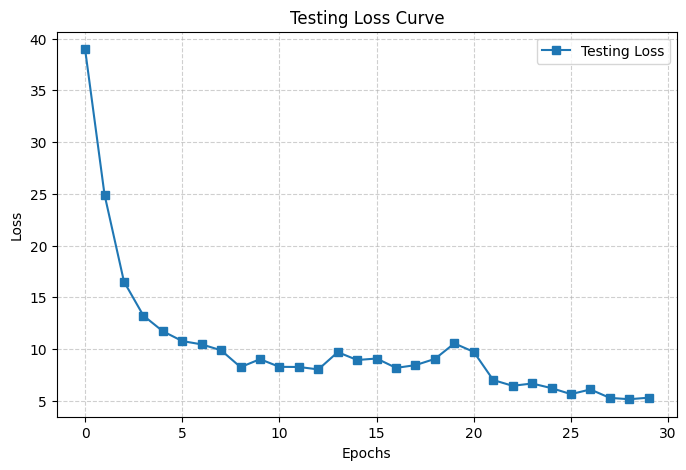

In [ ]:
import matplotlib.pyplot as plt

# Plot loss curves
plt.figure(figsize=(8, 5))
plt.plot(test1_loss_history, label="Testing Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Testing Loss Curve")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


## 2 NEW FNO MODEL (More Layers)

In [ ]:
# Define the Fourier Neural Operator (FNO) for 1D problems
class FNO2_1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO2_1d, self).__init__()

        """
        The overall structure of the Fourier Neural Operator (FNO):
        1. Lift the input to a higher-dimensional space using `self.linear_p`.
        2. Apply multiple layers of Fourier-based convolution (`SpectralConv1d`).
        3. Apply linear transformations (`Conv1d`) after each Fourier layer.
        4. Project the output to the desired final dimension (`self.linear_q` and `self.output_layer`).

        Input:  (batch_size, x=s, c=2) -> initial condition and spatial coordinate (u0(x), x)
        Output: (batch_size, x=s, c=1) -> solution at a later time step
        """

        # Number of Fourier modes
        self.modes1 = modes

        # Number of channels
        self.width = width

        self.padding = 1

        # Initial linear layer to lift the input dimension
        self.linear_p = nn.Linear(2, self.width)

        # Define 3 Fourier convolution layers (SpectralConv1d)
        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect4 = SpectralConv1d(self.width, self.width, self.modes1) #ADDED
        self.spect5 = SpectralConv1d(self.width, self.width, self.modes1) #ADDED


        # Define 1x1 convolution layers to refine local features after each Fourier layer
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)
        self.lin3 = nn.Conv1d(self.width, self.width, 1)
        self.lin4 = nn.Conv1d(self.width, self.width, 1)


        # Final linear layers to project to the output dimension
        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        # Activation function (Tanh) for non-linearity
        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    # Function to apply a linear transformation followed by activation
    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    # Forward pass of the FNO1d model
    def forward(self, x):
        """
        Steps:
        1. Lift the input to a higher-dimensional space.
        2. Apply spectral convolution layers followed by linear transformations.
        3. Project the output to the final shape.
        """

        # Step 1
        x = self.linear_p(x)

        x = x.permute(0, 2, 1)

        # Step 2
        x = self.fourier_layer(x, self.spect1, self.lin0)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        x = self.fourier_layer(x, self.spect3, self.lin2)
        x = self.fourier_layer(x, self.spect4, self.lin3)
        x = self.fourier_layer(x, self.spect5, self.lin4)


        # Permute back to (batch, grid_points, width) for the final linear layers
        x = x.permute(0, 2, 1)

        # Step 3
        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)  # Final projection to 1D output

        return x


## Training NEW FNO MODEL

In [ ]:
learning_rate = 0.001
epochs = 30
step_size = 50
gamma = 0.5

In [ ]:
modes = 16
width = 64
fno_2 = FNO2_1d(modes, width) # model

In [ ]:
optimizer = Adam(fno_2.parameters(), lr=learning_rate, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

mse_loss_fn = torch.nn.MSELoss()
mae_loss_fn = torch.nn.L1Loss()

train_mse_history = []
train_mae_history = []
train_rmse_history = []

test_mse_history = []
test_mae_history = []
test_r2_history = []
test_rmse_history = []
test_relative_l2_history = []

freq_print = 1

for epoch in range(epochs):
    fno_2.train()
    train_mse, train_mae, train_rmse = 0.0, 0.0, 0.0

    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()

        output_pred_batch = fno_2(input_batch).squeeze(2)

        loss_mse = mse_loss_fn(output_pred_batch, output_batch)
        loss_mse.backward()

        optimizer.step()

        loss_mae = mae_loss_fn(output_pred_batch, output_batch)
        loss_rmse = torch.sqrt(loss_mse)

        train_mse += loss_mse.item()
        train_mae += loss_mae.item()
        train_rmse += loss_rmse.item()

    train_mse /= len(training_set)
    train_mae /= len(training_set)
    train_rmse /= len(training_set)

    train_mse_history.append(train_mse)
    train_mae_history.append(train_mae)
    train_rmse_history.append(train_rmse)

    scheduler.step()

    fno_2.eval()
    test_mse, test_mae, test_rmse, test_r2, test2_relative_l2 = 0.0, 0.0, 0.0, 0.0, 0.0

    with torch.no_grad():
        for step, (input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = fno_2(input_batch).squeeze(2)

            mse = mse_loss_fn(output_pred_batch, output_batch)
            mae = mae_loss_fn(output_pred_batch, output_batch)
            rmse = torch.sqrt(mse)

            relative_l2 = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100

            ss_total = torch.sum((output_batch - torch.mean(output_batch)) ** 2)
            ss_residual = torch.sum((output_batch - output_pred_batch) ** 2)
            r2_score = 1 - (ss_residual / ss_total)

            test_mse += mse.item()
            test_mae += mae.item()
            test_rmse += rmse.item()
            test_relative_l2 += relative_l2.item()
            test_r2 += r2_score.item()

        test_mse /= len(testing_set)
        test_mae /= len(testing_set)
        test_rmse /= len(testing_set)
        test_relative_l2 /= len(testing_set)
        test_r2 /= len(testing_set)

        test_mse_history.append(test_mse)
        test_mae_history.append(test_mae)
        test_rmse_history.append(test_rmse)
        test_relative_l2_history.append(test_relative_l2)
        test_r2_history.append(test_r2)

        if epoch % freq_print == 0:
          print(f"\nEpoch: {epoch}")
          print(f"{'Metric':<20}{'Train':<20}{'Test'}")
          print("-" * 60)
          print(f"{'MSE':<20}{train_mse:<20f}{test_mse:.6f}")
          print(f"{'MAE':<20}{train_mae:<20f}{test_mae:.6f}")
          print(f"{'RMSE':<20}{train_rmse:<20f}{test_rmse:.6f}")
          print(f"{'R²':<20}{'-':<20}{test_r2:.6f}")  # R² is only for the test set
          print(f"{'Relative L2 (%)':<20}{'-':<20}{test_relative_l2:.6f}%")  # Only for test


Epoch: 0
Metric              Train               Test
------------------------------------------------------------
MSE                 0.281008            0.106701
MAE                 0.437903            0.289108
RMSE                0.489590            0.326071
R²                  -                   0.844158
Relative L2 (%)     -                   39.432734%

Epoch: 1
Metric              Train               Test
------------------------------------------------------------
MSE                 0.046261            0.031582
MAE                 0.172509            0.136536
RMSE                0.211491            0.175514
R²                  -                   0.953962
Relative L2 (%)     -                   21.623157%

Epoch: 2
Metric              Train               Test
------------------------------------------------------------
MSE                 0.017087            0.014569
MAE                 0.097833            0.087026
RMSE                0.128446            0.118644
R²         

In [ ]:
model_summary(fno_2)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|   linear_p.weight   |    128     |
|    linear_p.bias    |     64     |
|   spect1.weights1   |   65536    |
|   spect2.weights1   |   65536    |
|   spect3.weights1   |   65536    |
|   spect4.weights1   |   65536    |
|   spect5.weights1   |   65536    |
|     lin0.weight     |    4096    |
|      lin0.bias      |     64     |
|     lin1.weight     |    4096    |
|      lin1.bias      |     64     |
|     lin2.weight     |    4096    |
|      lin2.bias      |     64     |
|     lin3.weight     |    4096    |
|      lin3.bias      |     64     |
|     lin4.weight     |    4096    |
|      lin4.bias      |     64     |
|   linear_q.weight   |    2048    |
|    linear_q.bias    |     32     |
| output_layer.weight |     32     |
|  output_layer.bias  |     1      |
+---------------------+------------+
Total Trainable Params: 350785


350785

## Plot

Plot saved at: plots/fno2_1d_test_sample_804.png


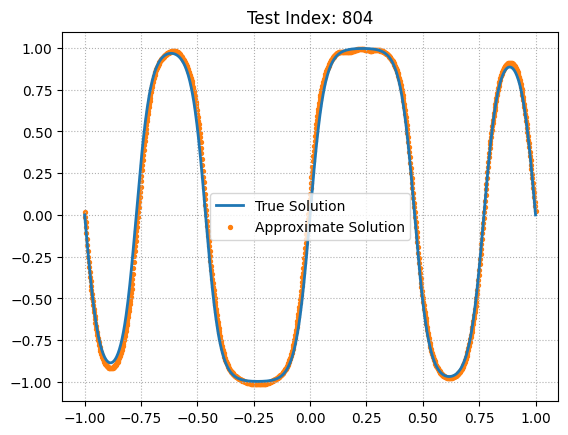

In [ ]:
single_plot(fno_2)

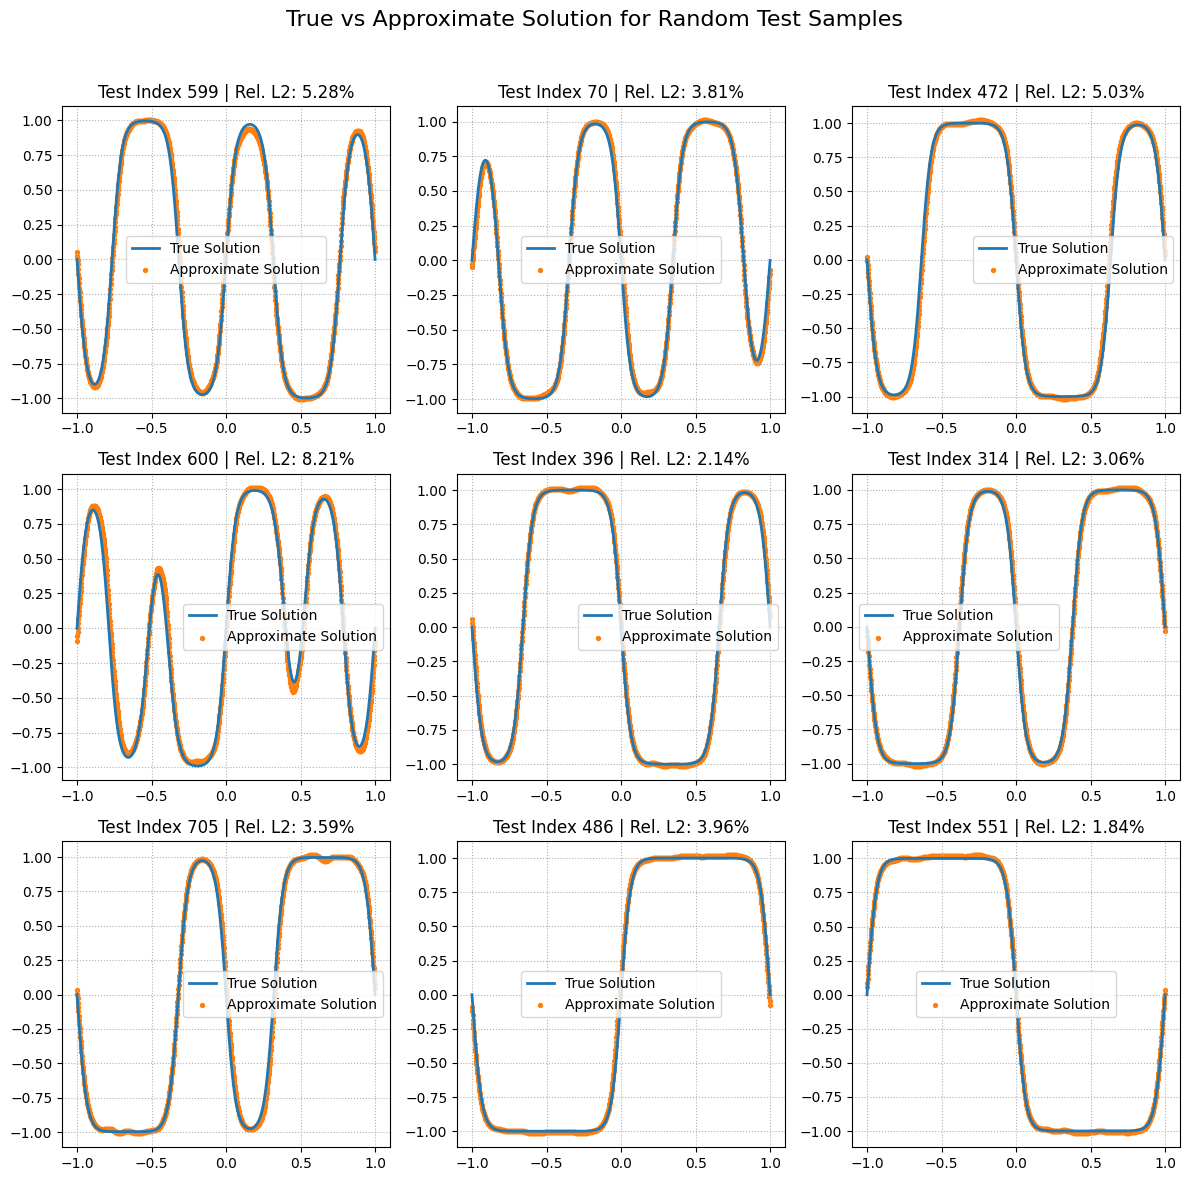

Plot saved at: plots/fno2_1dmodel_true_vs_approx_3x3_grid.png


<Figure size 640x480 with 0 Axes>

In [ ]:
true_vs_approx(fno_2)

## Checkpoints

### Saving the Model

In [ ]:
model = fno_2
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, "model2_checkpoint.pth")

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

checkpoint2 = {
    'model_name': model,
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_mse_history': train_mse_history,
    'train_mae_history': train_mae_history,
    'train_rmse_history': train_rmse_history,
    'test_mse_history': test_mse_history,
    'test_mae_history': test_mae_history,
    'test_rmse_history': test_rmse_history,
    'test_r2_history': test_r2_history,
    'test_relative_l2_history': test_relative_l2_history,
    'min_test_loss': min(test_mse_history),
    'total_params': total_params,
}
torch.save(checkpoint2, checkpoint_path)

fno_2_info = [checkpoint2.copy()]

print(f"Checkpoint saved successfully at: {checkpoint_path}")


Checkpoint saved successfully at: checkpoints/model2_checkpoint.pth


In [ ]:
fno_2_info = {
    'model_name': model.__class__.__name__,
    'test_mse_history': test_mse_history[-1],
    'test_mae_history': test_mae_history[-1],
    'test_rmse_history': test_rmse_history[-1],
    'test_r2_history': test_r2_history[-1],
    'test_relative_l2_history': test_relative_l2_history[-1],
    'min_test_loss': min(test_mse_history),
    'total_params': total_params,
}

# Convert the dictionary values to a list
fno_2_info_list = list(fno_2_info.values())



In [ ]:
fno_2_info_list

['FNO2_1d',
 0.0035700575564987956,
 0.029459158703684808,
 0.05702877471016513,
 0.9947888400819567,
 6.97250004231956,
 0.0018872735226371637,
 350785]

### Load Model Checkpoint

In [ ]:
checkpoint2 = torch.load('checkpoints/model2_checkpoint.pth')

model.load_state_dict(checkpoint2['model_state_dict'])
optimizer.load_state_dict(checkpoint2['optimizer_state_dict'])

epoch = checkpoint2['epoch']
train_loss_history = checkpoint2['train_mse_history']
test2_loss_history = checkpoint2['test_relative_l2_history']
min_test_loss = checkpoint2['min_test_loss']
total_params = checkpoint2['total_params']

print(f"Resuming from Epoch: {epoch}")
print(f"Total Trainable Parameters: {total_params}")
print(f"Final Training Loss: {train_mse_history[-1]}")
print(f"Final Testing Loss: {test_relative_l2_history[-1]}")
print(f"Lowest Testing Loss Achieved: {min_test_loss}")


Resuming from Epoch: 29
Total Trainable Parameters: 350785
Final Training Loss: 0.0021605803922284395
Final Testing Loss: 6.97250004231956
Lowest Testing Loss Achieved: 0.0018872735226371637


<ipython-input-38-f282217707fe>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint2 = torch.load('checkpoints/model2_checkpoint.pth')


### Access Training & Validation Logs

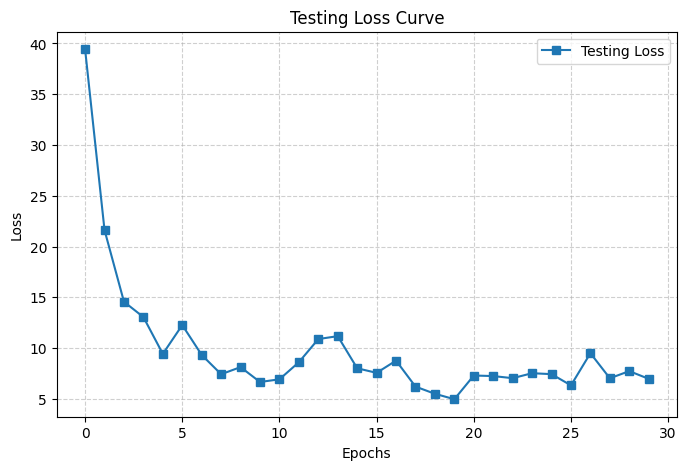

In [ ]:
import matplotlib.pyplot as plt

# Plot loss curves
plt.figure(figsize=(8, 5))
plt.plot(test2_loss_history, label="Testing Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Testing Loss Curve")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


## 3 CNN MODEL

In [ ]:
import torch
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, input_channels=1, output_channels=1):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv1d(256, 512, kernel_size=3, padding=1)

        self.conv7 = nn.Conv1d(512, output_channels, kernel_size=3, padding=1)  # Output layer

        self.pool = nn.AdaptiveAvgPool1d(1001)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Ensure x is 3D: [batch_size, channels, sequence_length]
        if len(x.shape) == 4:
            x = x.squeeze(-1)

        # Forward pass through the convolutional layers
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.conv7(x)

        x = self.pool(x)

        return x


In [ ]:
train_mse_history = []
train_mae_history = []
train_rmse_history = []
train_relative_l2_history = []

test_mse_history = []
test_mae_history = []
test_rmse_history = []
test_relative_l2_history = []
test_r2_history = []


In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_model = CNNModel(input_channels=2, output_channels=1).to(device)

optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

mse_loss_fn = nn.MSELoss()
mae_loss_fn = nn.L1Loss()

for epoch in range(epochs):
    cnn_model.train()
    train_mse, train_mae, train_rmse, train_relative_l2 = 0.0, 0.0, 0.0, 0.0

    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()

        input_batch = input_batch.view(input_batch.shape[0], 2, -1)
        output_pred_batch = cnn_model(input_batch).squeeze(1)

        loss_mse = mse_loss_fn(output_pred_batch, output_batch)
        loss_mse.backward()
        optimizer.step()

        loss_mae = mae_loss_fn(output_pred_batch, output_batch)
        loss_rmse = torch.sqrt(loss_mse)

        relative_l2 = torch.norm(output_pred_batch - output_batch) / torch.norm(output_batch)

        train_mse += loss_mse.item()
        train_mae += loss_mae.item()
        train_rmse += loss_rmse.item()
        train_relative_l2 += relative_l2.item()

    train_mse /= len(training_set)
    train_mae /= len(training_set)
    train_rmse /= len(training_set)
    train_relative_l2 /= len(training_set)

    train_mse_history.append(train_mse)
    train_mae_history.append(train_mae)
    train_rmse_history.append(train_rmse)
    train_relative_l2_history.append(train_relative_l2)

    scheduler.step()

    cnn_model.eval()
    test_mse, test_mae, test_rmse, test_r2, test_relative_l2 = 0.0, 0.0, 0.0, 0.0, 0.0

    with torch.no_grad():
        for step, (input_batch, output_batch) in enumerate(testing_set):
            input_batch = input_batch.view(input_batch.shape[0], 2, -1)
            output_pred_batch = cnn_model(input_batch).squeeze(1)

            mse = mse_loss_fn(output_pred_batch, output_batch)
            mae = mae_loss_fn(output_pred_batch, output_batch)
            rmse = torch.sqrt(mse)

            relative_l2 = torch.norm(output_pred_batch - output_batch) / torch.norm(output_batch)

            ss_total = torch.sum((output_batch - torch.mean(output_batch)) ** 2)
            ss_residual = torch.sum((output_batch - output_pred_batch) ** 2)
            r2_score = 1 - (ss_residual / ss_total)

            test_mse += mse.item()
            test_mae += mae.item()
            test_rmse += rmse.item()
            test_relative_l2 += relative_l2.item()
            test_r2 += r2_score.item()

        test_mse /= len(testing_set)
        test_mae /= len(testing_set)
        test_rmse /= len(testing_set)
        test_relative_l2 /= len(testing_set)
        test_r2 /= len(testing_set)

        test_mse_history.append(test_mse)
        test_mae_history.append(test_mae)
        test_rmse_history.append(test_rmse)
        test_relative_l2_history.append(test_relative_l2)
        test_r2_history.append(test_r2)

        if epoch % freq_print == 0:
          print(f"\nEpoch: {epoch}")
          print(f"{'Metric':<20}{'Train':<20}{'Test'}")
          print("-" * 60)
          print(f"{'MSE':<20}{train_mse:<20f}{test_mse:.6f}")
          print(f"{'MAE':<20}{train_mae:<20f}{test_mae:.6f}")
          print(f"{'RMSE':<20}{train_rmse:<20f}{test_rmse:.6f}")
          print(f"{'R²':<20}{'-':<20}{test_r2:.6f}")
          print(f"{'Relative L2 (%)':<20}{'-':<20}{test_relative_l2:.6f}%")


Epoch: 0
Metric              Train               Test
------------------------------------------------------------
MSE                 0.697413            0.676030
MAE                 0.787797            0.770403
RMSE                0.834957            0.821995
R²                  -                   0.016415
Relative L2 (%)     -                   0.991628%

Epoch: 1
Metric              Train               Test
------------------------------------------------------------
MSE                 0.667105            0.664483
MAE                 0.757198            0.752892
RMSE                0.816598            0.814684
R²                  -                   0.033382
Relative L2 (%)     -                   0.982766%

Epoch: 2
Metric              Train               Test
------------------------------------------------------------
MSE                 0.646427            0.649340
MAE                 0.737288            0.732537
RMSE                0.803525            0.805396
R²           

In [ ]:
model_summary(cnn_model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    192     |
|  conv1.bias  |     32     |
| conv2.weight |    6144    |
|  conv2.bias  |     64     |
| conv3.weight |   24576    |
|  conv3.bias  |    128     |
| conv4.weight |   49152    |
|  conv4.bias  |    128     |
| conv5.weight |   98304    |
|  conv5.bias  |    256     |
| conv6.weight |   393216   |
|  conv6.bias  |    512     |
| conv7.weight |    1536    |
|  conv7.bias  |     1      |
+--------------+------------+
Total Trainable Params: 574241


574241

Test Sample Index: 87
Relative L2 error:  124.68560791015625
Mean Absolute Error (MAE): 0.621459
Root Mean Squared Error (RMSE): 0.736695
R² Score: 0.179153


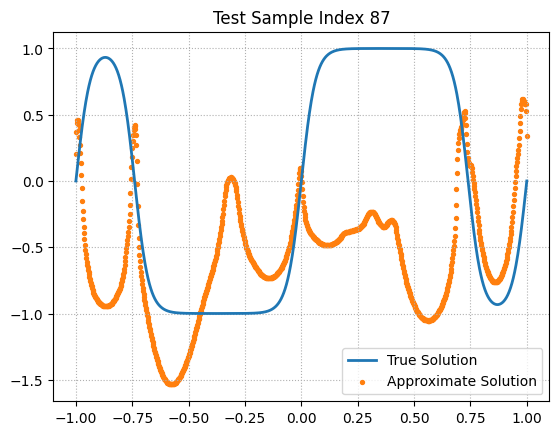

In [ ]:
idx_data = np.random.randint(0, len(input_function_test) - 1)

input_function_test_n = input_function_test[idx_data, :, :].unsqueeze(0)

input_function_test_n = input_function_test_n.permute(0, 2, 1)

output_function_test_n = output_function_test[idx_data, :].unsqueeze(0)

output_function_test_pred_n = cnn_model(input_function_test_n)


plt.figure()
plt.grid(True, which="both", ls=":")
plt.plot(
    input_function_test_n[0,1,:].detach(),
    output_function_test_n[0].detach(),
    label="True Solution",
    c="C0",
    lw=2
)
plt.scatter(
    input_function_test_n[0,1,:].detach(),
    output_function_test_pred_n[0].detach(),
    label="Approximate Solution",
    s=8,
    c="C1"
)

p = 2
err = (torch.mean(abs(output_function_test_n.detach().reshape(-1, ) - output_function_test_pred_n.detach().reshape(-1, )) ** p) /
       torch.mean(abs(output_function_test_n.detach()) ** p)) ** (1 / p) * 100

print("Test Sample Index:", idx_data)
print("Relative L2 error: ", err.item())
print(f"Mean Absolute Error (MAE): {mae.item():.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse.item():.6f}")
print(f"R² Score: {r2_score.item():.6f}")
plt.title(f"Test Sample Index {idx_data}")
plt.legend()

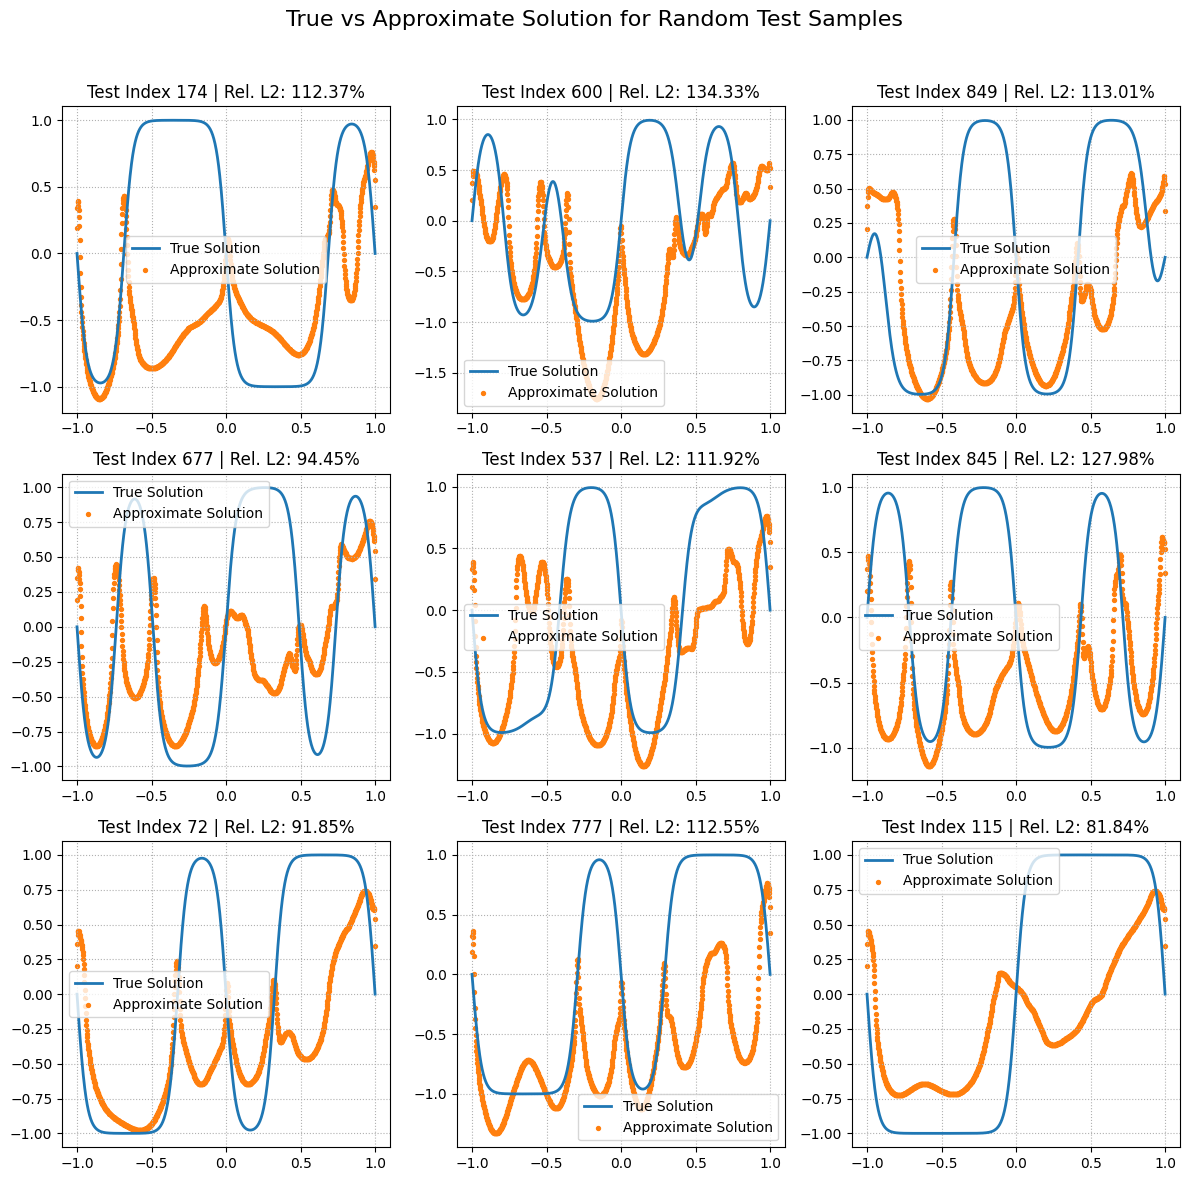

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

num_samples = 9
indices = np.random.randint(0, len(input_function_test) - 1, num_samples)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle("True vs Approximate Solution for Random Test Samples", fontsize=16)

p = 2

for i, idx_data in enumerate(indices):
    ax = axes[i // 3, i % 3]

    input_function_test_n = input_function_test[idx_data, :].unsqueeze(0)
    output_function_test_n = output_function_test[idx_data, :].unsqueeze(0)

    input_function_test_n = input_function_test_n.permute(0, 2, 1)

    output_function_test_pred_n = cnn_model(input_function_test_n)

    err = (torch.mean(abs(output_function_test_n.detach().reshape(-1, ) -
                          output_function_test_pred_n.detach().reshape(-1, )) ** p) /
           torch.mean(abs(output_function_test_n.detach()) ** p)) ** (1 / p) * 100

    ax.grid(True, which="both", ls=":")
    ax.plot(input_function_test_n[0, 1, :].detach(),
            output_function_test_n[0].detach(),
            label="True Solution",
            c="C0",
            lw=2)

    ax.scatter(input_function_test_n[0, 1, :].detach(),
               output_function_test_pred_n[0].detach(),
               label="Approximate Solution",
               s=8,
               c="C1")

    ax.set_title(f"Test Index {idx_data} | Rel. L2: {err:.2f}%")
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Saving the Model

In [ ]:
model = cnn_model
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, "model3_checkpoint.pth")

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

checkpoint3 = {
    'model_name': model,
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_mse_history': train_mse_history,
    'train_mae_history': train_mae_history,
    'train_rmse_history': train_rmse_history,
    'test_mse_history': test_mse_history,
    'test_mae_history': test_mae_history,
    'test_rmse_history': test_rmse_history,
    'test_r2_history': test_r2_history,
    'test_relative_l2_history': test_relative_l2_history,
    'min_test_loss': min(test_mse_history),
    'total_params': total_params,

torch.save(checkpoint3, checkpoint_path)
print(f"Checkpoint saved successfully at: {checkpoint_path}")


Checkpoint saved successfully at: checkpoints/model3_checkpoint.pth


In [ ]:
cnn_info = {
    'model_name': model.__class__.__name__,
    'test_mse_history': test_mse_history[-1],
    'test_mae_history': test_mae_history[-1],
    'test_rmse_history': test_rmse_history[-1],
    'test_r2_history': test_r2_history[-1],
    'test_relative_l2_history': test_relative_l2_history[-1],
    'min_test_loss': min(test_mse_history),
    'total_params': total_params,
}

# Convert the dictionary values to a list
cnn_info_list = list(cnn_info.values())



In [ ]:
cnn_info_list

['CNNModel',
 0.5846485416094462,
 0.6579244322246975,
 0.7629591034518348,
 0.14638512863053216,
 0.9212213582462735,
 0.5673424545261595,
 574241]

### Load Model Checkpoint

In [ ]:
checkpoint3 = torch.load('checkpoints/model3_checkpoint.pth')

model.load_state_dict(checkpoint3['model_state_dict'])
optimizer.load_state_dict(checkpoint3['optimizer_state_dict'])

epoch = checkpoint3['epoch']
train_loss_history = checkpoint3['train_mse_history']
test3_loss_history = checkpoint3['test_relative_l2_history']
min_test_loss = checkpoint3['min_test_loss']
total_params = checkpoint3['total_params']

cnn_info = [checkpoint3]

print(f"Resuming from Epoch: {epoch}")
print(f"Total Trainable Parameters: {total_params}")
print(f"Final Training Loss: {train_mse_history[-1]}")
print(f"Final Testing Loss: {test_relative_l2_history[-1]}")
print(f"Lowest Testing Loss Achieved: {min_test_loss}")


Resuming from Epoch: 29
Total Trainable Parameters: 574241
Final Training Loss: 0.5012539893388748
Final Testing Loss: 0.9212213582462735
Lowest Testing Loss Achieved: 0.5673424545261595


<ipython-input-49-68610ca20e1a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint3 = torch.load('checkpoints/model3_checkpoint.pth')


### Access Training & Validation Logs

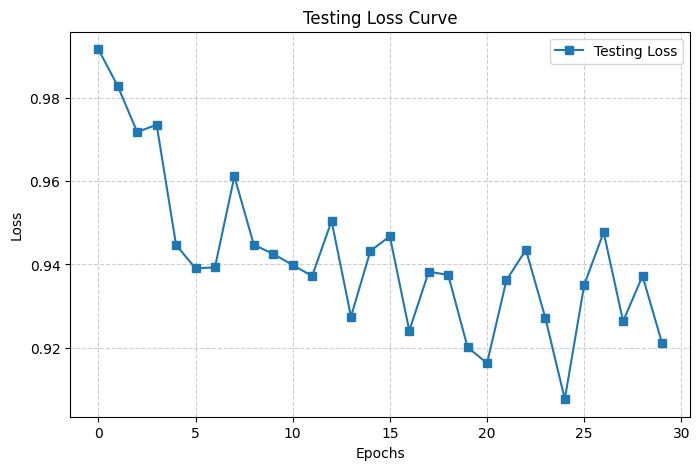

In [ ]:
import matplotlib.pyplot as plt

# Plot loss curves
plt.figure(figsize=(8, 5))
plt.plot(test3_loss_history, label="Testing Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Testing Loss Curve")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


## ALL 3 MODELS LOSS CURVE COMPARISON

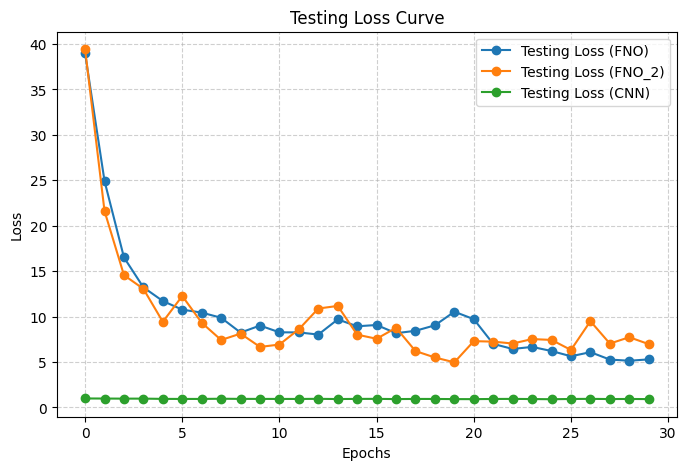

In [ ]:
import matplotlib.pyplot as plt

# Plot loss curves
plt.figure(figsize=(8, 5))
plt.plot(test1_loss_history, label="Testing Loss (FNO)", marker='o')
plt.plot(test2_loss_history, label="Testing Loss (FNO_2)", marker='o')
plt.plot(test3_loss_history, label="Testing Loss (CNN)", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Testing Loss Curve")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
import pandas as pd

def compare_models(models_info: list[list]) -> pd.DataFrame:
    """
    Creates a summary table comparing multiple models based on their evaluation metrics.

    Parameters:
    models_info: A list of lists, where each sublist contains:
        - Model name (str)
        - Test MSE (float)
        - Test MAE (float)
        - Test RMSE (float)
        - Test R² (float)
        - Test Relative L2 (%) (float)
        - Min Test Loss (float)
        - Total Parameters (int)

    Returns:
    pd.DataFrame: A DataFrame summarizing the models' performance.
    """
    columns = ["Model", "Test MSE", "Test MAE", "Test RMSE", "Test R²",
               "Test Relative L2 (%)", "Min Test Loss", "Total Parameters"]

    df = pd.DataFrame(models_info, columns=columns)
    return df


In [ ]:
compare_models([fno_info_list, fno_2_info_list, cnn_info_list])

,Model,Test MSE,Test MAE,Test RMSE,Test R²,Test Relative L2 (%),Min Test Loss,Total Parameters
0,FNO1d,0.002351,0.019859,0.043836,0.996572,5.293022,0.002130,211393
1,FNO2_1d,0.003570,0.029459,0.057029,0.994789,6.972500,0.001887,350785
2,CNNModel,0.584649,0.657924,0.762959,0.146385,0.921221,0.567342,574241


---